In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import scipy
import statsmodels.api as sm

In [22]:
def getData(path):
    df = pd.read_csv(path, sep=',', header=0, index_col=0)
    return df

names = pickle.load(open('../../data/hosts/common_names.p', 'rb'))
names['Chimp_pts'] = 'Pan_troglodytes_schweinfurthii'

bmr = getData('/Users/Sidney/Dropbox/siv/data/determinants/body_mass_rawdata.csv') # body mass values
hgd = getData('/Users/Sidney/Dropbox/siv/data/determinants/hostdistance_rawdata.csv') # host genetic distance
hgd_names = { i: i.split('|')[2] for i in list(hgd.columns.values)+list(hgd.index.values) } # fix taxa -> host names
hgd.rename(columns=hgd_names, index=hgd_names, inplace=True)
hgd.rename(index={'P._t._schweinfurthii': 'Pan_troglodytes_schweinfurthii'}, 
           columns = {'P._t._schweinfurthii': 'Pan_troglodytes_schweinfurthii'},
          inplace=True)

bf = getData('../../beast/main/discreteTraits/results/discreteTraits_2016-10-25_bf.csv') # Bayes factors

In [23]:
data = []
for from_host in bmr.index.values[1:]:
    for to_host in bmr.index.values[1:]:
        if from_host != to_host:
            transmission = 1 if bf.at[names[from_host], names[to_host]] >= 36.0 else 0
            bmr_val = np.log( bmr.at[from_host, 'mass'] / bmr.at[to_host, 'mass'])
            hgd_val = hgd.at[from_host, to_host]
            data.append({ 'log_bmr': bmr_val, 'hgd': hgd_val, 'transmission': transmission, 'intercept': 1 } )
            
data = pd.DataFrame(data, columns=['transmission', 'intercept', 'log_bmr', 'hgd', 'bmr_quantiles', 'hgd_quantiles'])

data['bmr_quantiles'] = pd.cut(data['log_bmr'], 5, labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
data['hgd_quantiles'] = pd.cut(data['hgd'], 5, labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
print data.head(5)

   transmission  intercept   log_bmr     hgd bmr_quantiles hgd_quantiles
0             0          1  0.726427  0.3171        40-60%        40-60%
1             0          1  0.726427  0.3203        40-60%        40-60%
2             0          1  0.554286  0.3188        40-60%        40-60%
3             1          1  0.726427  0.3164        40-60%        40-60%
4             0          1  0.206253  0.3295        40-60%        40-60%


In [24]:
bmr_logit = sm.Logit(data['transmission'], data[['log_bmr', 'intercept']]).fit()
hgd_logit = sm.Logit(data['transmission'], data[['hgd', 'intercept']]).fit()
print bmr_logit.summary()
print hgd_logit.summary()

Optimization terminated successfully.
         Current function value: 0.202398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184935
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           transmission   No. Observations:                  506
Model:                          Logit   Df Residuals:                      504
Method:                           MLE   Df Model:                            1
Date:                Thu, 22 Dec 2016   Pseudo R-squ.:               0.0008416
Time:                        12:26:15   Log-Likelihood:                -102.41
converged:                       True   LL-Null:                       -102.50
                                        LLR p-value:                    0.6779
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
log_bm

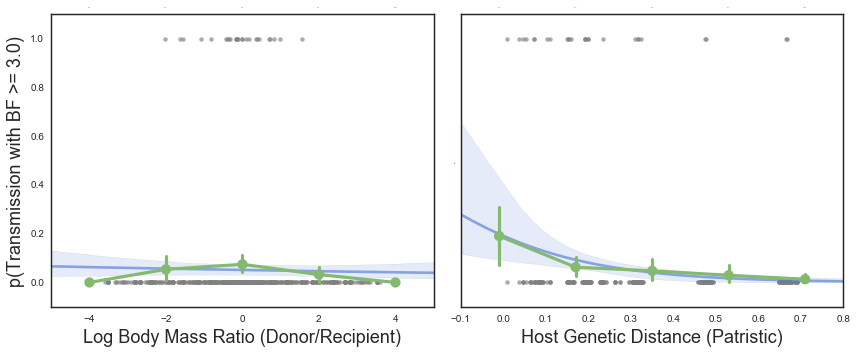

In [27]:
fig, (bmr_ax, hgd_ax) = plt.subplots(figsize=(12,5),nrows=1,ncols=2,sharey=True, facecolor='w') # Note shared Y axis

bmr_logit = sns.regplot(data['log_bmr'], data['transmission'], ax=bmr_ax, 
                        line_kws = {'color':'#547BD3', 'alpha': 0.65}, 
                        scatter_kws={'color': 'gray', 'alpha': 0.65}, logistic=True)
hgd_logit = sns.regplot(data['hgd'], data['transmission'], ax=hgd_ax,
                        line_kws = {'color':'#547BD3', 'alpha': 0.65}, 
                        scatter_kws={'color': 'gray', 'alpha': 0.65}, logistic=True)

hgd_ax2 = hgd_ax.twiny()
bmr_ax2=bmr_ax.twiny()

sns.pointplot(x=data['bmr_quantiles'], y=data['transmission'], ax=bmr_ax2, color='#83BA70')
sns.pointplot(x=data['hgd_quantiles'], y=data['transmission'], ax=hgd_ax2, color='#83BA70')

hgd_ax.set_xlabel('Host Genetic Distance (Patristic)', size=18)
bmr_ax.set_ylabel('p(Transmission with BF >= 3.0)', size=18)
bmr_ax.set_xlabel('Log Body Mass Ratio (Donor/Recipient)', size=18)
hgd_ax.set_ylabel(None, size=0)

hgd_ax2.tick_params(axis='x',labelsize=0,size=0)
bmr_ax2.tick_params(axis='x', labelsize=0, size=0)
hgd_ax2.set_xlabel('')
bmr_ax2.set_xlabel('')
hgd_ax.set_ylim(-0.1, 1.1)
bmr_ax.set_ylim(-0.1, 1.1)
hgd_ax2.set_ylim(-0.1, 1.1)
bmr_ax2.set_ylim(-0.1, 1.1)

sns.set_style('white')
plt.tight_layout()
plt.savefig('Fig4_Predictors.png', bbox_inches='tight', dpi=300)


### Figure 4: Cross-species transmission is driven by exposure and constrained by host genetic distance.  
For each pair of host species, we **(A)** calculated the log ratio of their average body masses and **(B)** found the patristic genetic distance between them (from a maximum-likelihood tree of mtDNA). To investigate the association of these predictors with cross-species transmission, we treated transmission as a binary variable: 0 if the Bayes factor for the transmission (as inferred by the discrete traits model) was < 3.0, and 1 for a Bayes factor >= 3.0. Each plot shows raw predictor data in gray; the quantiles of the predictor data in green; and the logistic regression and 95% CI in blue. The logistic regression and 95% CI are shown in black.